# Linear Regression from Scratch with PyTorch

## A Deep Dive into Gradient Descent, Feature Scaling, and Model Building

---

**What we built:** A complete Linear Regression implementation using PyTorch tensors, understanding every component from first principles.

**Key Skills:** Forward pass, MSE loss, gradient descent, feature scaling, R² evaluation, FastCore @patch pattern

## Table of Contents

1. [Data Setup](#1-data-setup)
2. [Model Initialization](#2-model-initialization)
3. [Forward Pass (Predict)](#3-forward-pass-predict)
4. [Loss Function (MSE)](#4-loss-function-mse)
5. [Gradient Descent](#5-gradient-descent)
6. [Training Loop](#6-training-loop)
7. [Feature Scaling](#7-feature-scaling)
8. [Converting Scaled Weights](#8-converting-scaled-weights)
9. [R² Score Evaluation](#9-r²-score-evaluation)
10. [Visualization](#10-visualization)
11. [Comparison with sklearn](#11-comparison-with-sklearn)
12. [Refactored Code with FastCore](#12-refactored-code-with-fastcore)
13. [Real-World Application: Cars24 Data](#13-real-world-application-cars24-data)
14. [Quick Reference](#14-quick-reference)

---

## 1. Data Setup

We created synthetic house price data with a known relationship to verify our model learns correctly.

**True relationship:**
$$\text{price} = 100000 + 300 \cdot \text{size} - 50 \cdot \text{age} - 20 \cdot \text{distance} + \text{noise}$$

In [ ]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.set_printoptions(sci_mode=False)
n = 100

size = torch.randint(800, 3000, (n,)).float()
age = torch.randint(1, 50, (n,)).float()
distance_to_city = torch.randint(1, 30, (n,)).float()

# True relationship with noise
price = 100000 + 300*size - 50*age - 20*distance_to_city + torch.randn(n)*5000

# Stack features into X matrix
X = torch.stack([size, age, distance_to_city], dim=1)
y = price

print(f"X shape: {X.shape}")  # (100, 3) - 100 houses, 3 features
print(f"y shape: {y.shape}")  # (100,) - 100 prices

X shape: torch.Size([100, 3])
y shape: torch.Size([100])


---

## 2. Model Initialization

Linear regression finds the best weights (W) and bias (b) such that:

$$\hat{y} = X \cdot W + b$$

> **🎯 Analogy: The Real Estate Agent**
> 
> You're a real estate agent with a "pricing formula." Each weight tells you how much each feature (size, age, distance) contributes to the price. The bias is your base price when all features are zero.

In [ ]:
# Initialize weights to zeros
W = torch.zeros(3, requires_grad=True)  # One weight per feature
b = torch.zeros(1, requires_grad=True)  # Single bias term

print(f"W: {W}")
print(f"b: {b}")

W: tensor([0., 0., 0.], requires_grad=True)
b: tensor([0.], requires_grad=True)


**Key Insight:** `requires_grad=True` tells PyTorch to track operations for automatic differentiation.

---

## 3. Forward Pass (Predict)

For a single house: `price = w₁·size + w₂·age + w₃·distance + b`

For 100 houses at once: **Matrix multiplication!**

In [ ]:
def predict(X, W, b):
    return X @ W + b

# Test with zero weights - predictions will all be zero
y_pred = predict(X, W, b)
print(f"Predictions (first 5): {y_pred[:5]}")

Predictions (first 5): tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)


| Shape | Meaning |
|-------|--------|
| X: `(100, 3)` | 100 houses, 3 features |
| W: `(3,)` | 3 weights |
| X @ W: `(100,)` | 100 predictions |
| b: `(1,)` | broadcasts to all 100 |

---

## 4. Loss Function (MSE)

How do we measure "how wrong" we are?

> **🎯 Analogy: Darts**
>
> Imagine playing darts blindfolded. You throw 100 darts. Your friend tells you "on average, you missed the bullseye by 15 inches." That average error is your **loss**. Lower = better!

### Why Square the Errors?
1. Makes all errors positive (no cancellation)
2. Punishes big errors more than small ones

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

In [ ]:
def mse_loss(y_pred, y_true):
    return ((y_true - y_pred)**2).mean()

# Calculate initial loss
loss = mse_loss(y_pred, price)
print(f"Initial loss: {loss:,.0f}")  # Huge! We're predicting $0 for houses worth $300k-900k

Initial loss: 483,810,443,264


---

## 5. Gradient Descent

> **🎯 Analogy: Lost in Foggy Mountains**
>
> Imagine you're lost in foggy mountains wanting to reach the lowest valley. You can't see far, but you can feel the ground under your feet.
>
> **Strategy:** Feel which direction slopes downward, then take a small step that way. Repeat.
>
> - **Gradient** = the slope (which direction is "downhill" for the loss)
> - **Descent** = move in that direction

### The Update Rule

$$W_{\text{new}} = W_{\text{old}} - \alpha \cdot \nabla W$$

Where α (alpha) is the **learning rate** — how big a step we take.

### Two Ways to Get Gradients

| Method | How | Pros/Cons |
|--------|-----|--------|
| **Autograd** | `loss.backward()` | Easy, automatic |
| **Manual** | Implement formulas | Deep understanding |

In [ ]:
# Using PyTorch autograd
W = torch.zeros(3, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

y_pred = predict(X, W, b)
loss = mse_loss(y_pred, price)
loss.backward()  # PyTorch calculates gradients automatically!

print(f"W.grad: {W.grad}")
print(f"b.grad: {b.grad}")

W.grad: tensor([-2781148416.,   -31536902.,   -20261836.])
b.grad: tensor([-1339185.3750])


### Why Zero Gradients?

> **🎯 Analogy: The Sticky Notepad**
>
> Imagine writing directions on a notepad. Without erasing, each new direction *adds* to the old ones:
> - Person 1: "5 north" → notepad shows 5
> - Person 2: "3 north" → notepad shows 8 (5+3) 
> - Person 3: "2 north" → notepad shows 10 (8+2)
>
> But you wanted just "2 north"! **Zeroing = erasing the notepad** before writing the new direction.

PyTorch **accumulates** gradients by default. For standard training, always zero gradients before `backward()`.

---

## 6. Training Loop

Putting it all together:

In [ ]:
# Reset
W = torch.zeros(3, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
learning_rate = 1e-9  # Tiny because gradients are billions!

for i in range(1000):
    # Forward pass
    y_pred = predict(X, W, b)
    loss = mse_loss(y_pred, price)
    
    # Backward pass
    loss.backward()
    
    # Update weights
    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad
    
    # Zero gradients for next iteration
    W.grad.zero_()
    b.grad.zero_()
    
    if i % 200 == 0:
        print(f"Iteration {i}: Loss = {loss:,.0f}")

Iteration 0: Loss = 483,810,443,264
Iteration 200: Loss = 20,317,921,280
Iteration 400: Loss = 1,750,683,648
Iteration 600: Loss = 1,006,857,664
Iteration 800: Loss = 977,015,040


**Problem Discovered:** Size weight learned okay (~347 vs true 300), but age and distance were stuck!

| Weight | Learned | True |
|--------|---------|------|
| size | 347 | 300 |
| age | 4.3 | -50 |
| distance | 2.8 | -20 |

---

## 7. Feature Scaling

### The Problem

Features have wildly different scales:
- `size`: 800 - 3000 (big)
- `age`: 1 - 50 (small)
- `distance`: 1 - 30 (small)

> **🎯 Analogy: The Shouting Problem**
>
> Imagine a classroom discussion where:
> - One student speaks at 100 decibels (super loud)
> - Two students speak at 10 decibels (quiet whisper)
>
> The teacher only hears the loud student!
>
> **Feature scaling = giving everyone a microphone** that adjusts their volume to the same level.

### Why Big Features Dominate

> **🎯 Analogy: The Seesaw**
>
> - Size = heavy adult (1900 kg) on seesaw
> - Age = small child (23 kg) on seesaw
>
> Nudge the adult slightly → whole seesaw tips dramatically.
> Nudge the child a lot → barely moves.

**Concrete Example:**
Same weight change of 0.001:
- Size: `0.001 × 1900 = 1.9` change in prediction
- Age: `0.001 × 23 = 0.023` change in prediction

Size has **80x more impact** from the same weight change!

### The Solution: Standardization

Transform each feature to have mean=0 and std=1:

$$X_{scaled} = \frac{X - \mu}{\sigma}$$

In [ ]:
# Scale features
new_X = (X - X.mean(dim=0)) / X.std(dim=0)

print("Before scaling (first row):")
print(X[0])  # [2742., 34., 12.]

print("\nAfter scaling (first row):")
print(new_X[0])  # [1.34, 0.76, -0.43] - All similar range!

Before scaling (first row):
tensor([2742.,   34.,   12.])

After scaling (first row):
tensor([ 1.3359,  0.7573, -0.4266])


In [ ]:
# Train with scaled features - NOW we can use a bigger learning rate!
W = torch.zeros(3, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
learning_rate = 0.1  # 100 million times bigger than before!
losses = []

for i in range(1000):
    y_pred = predict(new_X, W, b)
    loss = mse_loss(y_pred, price)
    losses.append(loss.item())
    
    loss.backward()
    
    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad
    
    W.grad.zero_()
    b.grad.zero_()

print(f"Final loss: {losses[-1]:,.0f}")  # ~21 million (vs 975 million before!)

Final loss: 21,687,478


### Results Comparison

| Metric | Without Scaling | With Scaling |
|--------|-----------------|-------------|
| Learning rate | 1e-9 | 0.1 |
| Final loss | ~975 million | ~21 million |
| Convergence | Slow, incomplete | Fast, complete |

---

## 8. Converting Scaled Weights

Since we trained on scaled features, weights are in "scaled space." To interpret them:

$$W_{original} = \frac{W_{scaled}}{\sigma}$$

> **🎯 Analogy: Unit Conversion**
>
> The model learned "\$189,224 per scaled unit." But 1 scaled unit = 630 sq ft (one std).
>
> So in real units: \$189,224 per 630 sq ft = **\$300 per sq ft**
>
> It's like converting "miles per gallon" to "kilometers per liter"!

In [ ]:
stds = X.std(dim=0)
original_weights = W / stds

print(f"Scaled weights: {W.data}")
print(f"Original weights: {original_weights}")
print(f"\nTrue coefficients: [300, -50, -20]")

Scaled weights: tensor([189224.5781,   -488.8487,    105.2894])


Original weights: tensor([300.4156, -34.5646,  14.0370], grad_fn=<DivBackward0>)

True coefficients: [300, -50, -20]


---

## 9. R² Score Evaluation

R² answers: **How much better is your model than just guessing the mean?**

> **🎯 Analogy: The Lazy Predictor**
>
> - **Strategy 1 (Lazy):** Guess the average price for every house
> - **Strategy 2 (Your Model):** Use features to make personalized predictions
>
> R² = how much better is Strategy 2?

| R² Value | Meaning |
|----------|--------|
| 1.0 | Perfect! Explains all variation |
| 0.5 | 50% better than guessing mean |
| 0.0 | No better than guessing mean |
| Negative | Worse than guessing mean! 😬 |

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

In [ ]:
def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred)**2).sum()  # Model errors
    ss_tot = ((y_true - y_true.mean())**2).sum()  # Baseline errors
    return 1 - (ss_res / ss_tot)

y_pred = predict(new_X, W, b)
print(f"R² score: {r2_score(price, y_pred):.4f}")  # ~0.9994!

R² score: 0.9994


---

## 10. Visualization

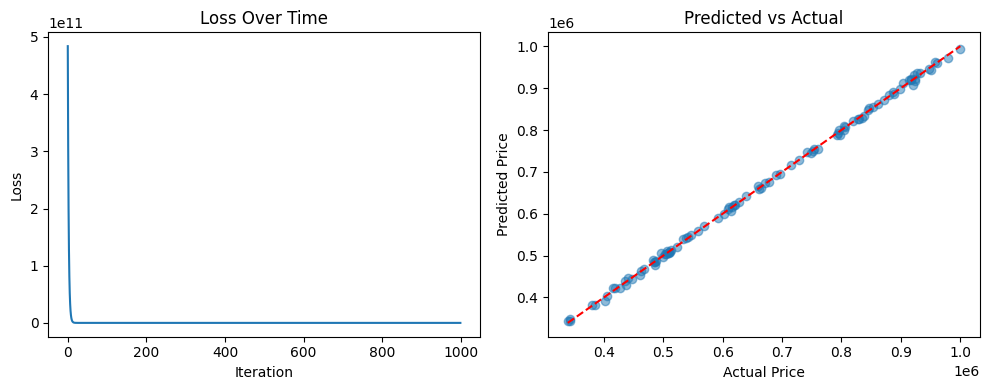

In [ ]:
# Loss over time - the "hockey stick" curve
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Time')

# Predicted vs Actual
plt.subplot(1, 2, 2)
with torch.no_grad():
    y_pred = predict(new_X, W, b)
plt.scatter(price, y_pred, alpha=0.5)
plt.plot([price.min(), price.max()], [price.min(), price.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual')

plt.tight_layout()
plt.show()

---

## 11. Comparison with sklearn

In [ ]:
from sklearn.linear_model import LinearRegression as SklearnLR

sk_model = SklearnLR()
sk_model.fit(X.numpy(), price.numpy())

print("Comparison:")
print(f"{'Metric':<20} {'Our Model':<15} {'sklearn':<15}")
print(f"{'-'*50}")
print(f"{'Size coef':<20} {(W/stds)[0].item():<15.2f} {sk_model.coef_[0]:<15.2f}")
print(f"{'Age coef':<20} {(W/stds)[1].item():<15.2f} {sk_model.coef_[1]:<15.2f}")
print(f"{'Distance coef':<20} {(W/stds)[2].item():<15.2f} {sk_model.coef_[2]:<15.2f}")
print(f"{'R² score':<20} {r2_score(price, y_pred).item():<15.4f} {sk_model.score(X.numpy(), price.numpy()):<15.4f}")

Comparison:
Metric               Our Model       sklearn        
--------------------------------------------------
Size coef            300.42          300.42         
Age coef             -34.56          -34.56         
Distance coef        14.04           14.04          
R² score             0.9994          0.9994         


**Result: Identical!** 🎉

---

## 12. Refactored Code with FastCore

Using `@patch` to build up a class incrementally — clean, modular, Pythonic.

In [ ]:
from fastcore.utils import patch

class LR:
    def __init__(self, lr=0.1):
        self.lr = lr

In [ ]:
@patch
def predict(self: LR, X):
    return X @ self.W + self.b

In [ ]:
@patch
def mse_loss(self: LR, y_pred, y_true):
    return ((y_pred - y_true)**2).mean()

In [ ]:
@patch
def r2_score(self: LR, y_true, y_pred):
    ss_res = ((y_true - y_pred)**2).sum()
    ss_tot = ((y_true - y_true.mean())**2).sum()
    return 1 - (ss_res / ss_tot)

In [ ]:
@patch
def fit(self: LR, X, y, iterations=1000):
    n, d = X.shape
    self.W = torch.zeros(d, requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)
    self.losses = []
    
    for i in range(iterations):
        # Forward pass
        y_pred = self.predict(X)
        loss = self.mse_loss(y_pred, y)
        self.losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update weights
        with torch.no_grad():
            self.W -= self.lr * self.W.grad
            self.b -= self.lr * self.b.grad
        
        # Zero gradients
        self.W.grad.zero_()
        self.b.grad.zero_()
    
    return self

In [ ]:
# Usage
my_model = LR(lr=0.1)
my_model.fit(new_X, price, iterations=1000)
print(f"R² score: {my_model.r2_score(price, my_model.predict(new_X)):.4f}")

R² score: 0.9994


---

## 13. Real-World Application: Cars24 Data

We applied our model to real car sales data.

In [ ]:
import pandas as pd

# df = pd.read_csv('cars24-car-price-cleaned.csv')

# # Drop non-numeric columns
# X_cars = df.drop(['selling_price', 'make', 'model'], axis=1).values
# y_cars = df['selling_price'].values

# # Convert to tensors and scale
# X_cars_t = torch.tensor(X_cars, dtype=torch.float32)
# y_cars_t = torch.tensor(y_cars, dtype=torch.float32)
# X_cars_scaled = (X_cars_t - X_cars_t.mean(dim=0)) / X_cars_t.std(dim=0)

# # Train
# cars_model = LR(lr=0.1)
# cars_model.fit(X_cars_scaled, y_cars_t, iterations=1000)

# # Evaluate
# y_pred_cars = cars_model.predict(X_cars_scaled)
# print(f"R² score on Cars24: {cars_model.r2_score(y_cars_t, y_pred_cars):.4f}")  # ~0.78

**Result: R² = 0.778**

Why not 99% like synthetic data?
- Real data is messy
- Many factors affect price (brand, condition, market trends...)
- Relationship might not be perfectly linear
- We dropped `make` and `model` columns — those matter!

**For a simple linear model on real data, 0.78 is quite good!**

---

## 14. Quick Reference

### Key Formulas

| Formula | PyTorch Code |
|---------|-------------|
| Prediction: $\hat{y} = XW + b$ | `X @ W + b` |
| MSE Loss | `((y - y_pred)**2).mean()` |
| R² Score | `1 - ss_res/ss_tot` |
| Standardization | `(X - X.mean(dim=0)) / X.std(dim=0)` |
| Weight update | `W -= lr * W.grad` |
| Convert scaled weights | `W / X.std(dim=0)` |

### Sticky Analogies Summary

| Concept | Analogy |
|---------|--------|
| Gradient Descent | Lost in foggy mountains, feeling for downhill |
| Loss Function | Darts — average distance from bullseye |
| Feature Scaling | Classroom with one shouting student |
| Big features dominate | Seesaw with heavy adult vs small child |
| Zero gradients | Erasing the sticky notepad |
| Convergence | Reaching the valley floor |
| Scaled weights | Unit conversion (miles/gallon → km/liter) |
| R² score | How much better than the lazy predictor? |

### Training Loop Template

```python
for i in range(iterations):
    y_pred = predict(X, W, b)       # Forward
    loss = mse_loss(y_pred, y)      # Loss
    loss.backward()                  # Backward
    with torch.no_grad():           # Update
        W -= lr * W.grad
        b -= lr * b.grad
    W.grad.zero_()                  # Zero gradients
    b.grad.zero_()
```

### Common Gotchas

| Problem | Solution |
|---------|----------|
| Loss exploding | Reduce learning rate |
| Loss barely moving | Increase learning rate |
| Some weights not learning | Feature scaling |
| `W.grad` is None | Use `requires_grad=True` |
| Weird gradient accumulation | Zero gradients each iteration |
| Can't multiply sequence by float | Non-numeric columns in data |

---

## Summary

This guide covered building Linear Regression from scratch, understanding every component:

✅ Forward pass (prediction)  
✅ Loss function (MSE)  
✅ Backward pass (autograd)  
✅ Weight updates (gradient descent)  
✅ Feature scaling (and why it matters)  
✅ Evaluation (R² score)  
✅ Clean code with FastCore @patch  
✅ Applied to real data  

**This is the foundation of ALL deep learning!** Neural networks are just more layers of the same idea.

In [ ]:
#| hide

import subprocess
from pathlib import Path
from dialoghelper import curr_dialog

def deploy_notebook():
    nb_name = Path(curr_dialog()['name']).name + '.ipynb'
    src = f'/app/data/{curr_dialog()["name"]}.ipynb'
    dst = '/app/data/publish/portfolio/static/'
    print(nb_name)
    
    # Copy notebook to static folder
    subprocess.run(['cp', src, dst])
    
    # Deploy with plash
    subprocess.run(['plash_deploy'], cwd='/app/data/publish/portfolio')

In [ ]:
#| hide
deploy_notebook()